In [1]:
import json

data =json.load(open('private/main_store_data.json'))
data.keys()

dict_keys(['step1', 'step2', 'step3'])

## Read JSON data

**TODO: fix dashboard design**

There is currently a design flaw: we need to have the same age groups in both the GIM and ICU pathways in order to compute total GIM bed occupancy by age group, as ICU patients may have
pre-ICU and post-ICU stays in the GIM.

This is not currently enforced by the dashboard design.

In [2]:
from itertools import chain
import reliability.Distributions as dist
from dataclasses import dataclass

def parse_key(key: str):
    # key format: "('pathway', 'outcome', 'age_group')"
    key = key.strip("()")
    segments = [seg.strip(" '") for seg in key.split(",")]
    return {
        'pathway': segments[0],
        'outcome': segments[1],
        'age_group': segments[2],
    }

def get_all_age_groups(data):
    """Get a set of all age groups present in the GIM or ICU patient data.

    We expect to extract from `data` a set of dicts like:
    {'pathway': 'gim', 'outcome': 'survived', 'age_group': (0, 15)}
    from which we want to get the unique age_group values only.
    We assume that the age groups are the same across pathways and outcomes.
    """
    return set(chain.from_iterable(
    [[g['age_group'] for g in l['groups']] for l in data.values()]
))

def parse_gim(d: dict):
    return {
        'p_label': d['probability'],
        'groups': [
            parse_key(k) | v for k, v in d['label_groups'].items()
        ],
        'dist': d['los_fit']['distribution'],
        'params': d['los_fit']['parameters']
    }

gim_data = {k:parse_gim(d) for k, d in data['step3']['los_fit_results']['gim'].items()}

def parse_pre_icu(d: dict):
    return {
        'p_label': d['probability'],
        'groups': [
            parse_key(k) | v for k, v in d['label_groups'].items()
        ],
        'prob_pre_icu': d['prob_pre_icu'],\
        'dist': d['pre_icu_los_fit']['distribution'],
        'params': d['pre_icu_los_fit']['parameters']
    }

def parse_icu(d: dict):
    return {
        'p_label': d['probability'],
        'groups': [
            parse_key(k) | v for k, v in d['label_groups'].items()
        ],
        'dist': d['icu_los_fit']['distribution'],
        'params': d['icu_los_fit']['parameters']
    }

def parse_post_icu(d: dict):
    return {
        'p_label': d['probability'],
        'groups': [
            parse_key(k) | v for k, v in d['label_groups'].items()
        ],
        'prob_post_icu': d['prob_post_icu'],
        'dist': d['post_icu_los_fit']['distribution'],
        'params': d['post_icu_los_fit']['parameters']
    }

pre_icu_data = {k:parse_pre_icu(d) for k, d in data['step3']['los_fit_results']['icu'].items()}
icu_data = {k:parse_icu(d) for k, d in data['step3']['los_fit_results']['icu'].items()}
post_icu_data = {k:parse_post_icu(d) for k, d in data['step3']['los_fit_results']['icu'].items()}

In [3]:
get_all_age_groups(gim_data)

{'0-15', '16-64', '65+'}

In [4]:
get_all_age_groups(icu_data)

{'0-15', '16-64', '65+'}

## Read group data

Get a mapping of (pathway, outcome, age_group) to labels

In [5]:
def in_label(pathway, outcome, age_group, groups):
    """Check if a given pathway, outcome, and age group combination is present in the groups."""
    for g in groups:
        if g['pathway'] == pathway and g['outcome'] == outcome and g['age_group'] == age_group:
            return g['p_in_label']
    return None

In [6]:
def get_dist(dist_name, params):
    if dist_name == 'Lognormal_3P':
        return dist.Lognormal_Distribution(*params)
    else:
        # TODO: add support for other distributions as needed
        raise ValueError(f"Unsupported distribution: {dist_name}")

### Data structure for GIM-only patients

In [7]:
GroupTuple = tuple[str, str, str] # (pathway, outcome, age_group)

@dataclass
class GimLabelInfo:
    """Information about a grouping label for GIM patients.
    
    Includes its probability, length of stay distribution, and group probabilities.
    Each label corresponds to a single length-of-stay distribution, and may contain multiple
    groups differentiated by outcome and age group.

    TODO: support for other distributions as needed (currently only lognormal is supported).
    """

    p_label: float
    """Probability that a patient belongs to this label, i.e. P(label).
    
    Probabilities across all GimLabelInfo and IcuLabelInfo instances should sum to 1.
    """

    los_dist: dist.Lognormal_Distribution
    """Length of stay distribution for this label."""

    groups: dict[GroupTuple, float]
    """Mapping of groups to their probabilities within this label, i.e. P(group | label)."""


class GimInfo:
    """Complete information about GIM groups and labels in the model."""

    def __init__(self):
        """Initialize empty mappings for labels and groups."""

        self.label_to_group = dict[str, GimLabelInfo]()
        """Mapping of label names to their corresponding GimLabelInfo."""

        self.group_to_label = dict[GroupTuple, str]()
        """Mapping of groups to their corresponding label names."""
    
    def add_label(self, label: str, p_label: float, los_dist: dist.Lognormal_Distribution):
        """Add a new label with its probability and length of stay distribution.
        
        TODO: support for other distributions as needed
        """
        init_info = {
            'p_label': p_label,
            'los_dist': los_dist,
            'groups': dict[GroupTuple, float]()
        }
        self.label_to_group[label] = GimLabelInfo(**init_info)
    
    def add_group_to_label(self, group: GroupTuple, label: str, p_in_label: float):
        """Add a new group to a label with its probability within that label."""
        self.group_to_label[group] = label
        self.label_to_group[label].groups[group] = p_in_label

In [8]:
gim_info = GimInfo()

for outcome in ['survived', 'died']:
    for age_group in get_all_age_groups(gim_data):
        for label, label_data in gim_data.items():
            # Find the probability of the label and the probability of the group within the label
            p_label = label_data['p_label']
            p_in_label = in_label('gim', outcome, age_group, label_data['groups'])

            # Skip if this group is not present
            if p_in_label is None or p_in_label == 0:
                continue

            # Create the label record if it doesn't exist
            if label not in gim_info.label_to_group:
                gim_info.add_label(
                    label=label,
                    p_label=p_label,
                    los_dist=get_dist(label_data['dist'], label_data['params'])
                )
            
            # Add the group to label mapping
            group_tuple = ('gim', outcome, age_group)
            gim_info.add_group_to_label(
                group=group_tuple,
                label=label,
                p_in_label=p_in_label
            )

In [9]:
gim_info.group_to_label

{('gim', 'survived', '16-64'): '2',
 ('gim', 'survived', '65+'): '3',
 ('gim', 'survived', '0-15'): '1',
 ('gim', 'died', '16-64'): '4',
 ('gim', 'died', '65+'): '4'}

In [10]:
gim_info.label_to_group

{'2': GimLabelInfo(p_label=0.3715898400752587, los_dist=<reliability.Distributions.Lognormal_Distribution object at 0x7906f1f56510>, groups={('gim', 'survived', '16-64'): 1}),
 '3': GimLabelInfo(p_label=0.39040451552210725, los_dist=<reliability.Distributions.Lognormal_Distribution object at 0x7906f1f22fd0>, groups={('gim', 'survived', '65+'): 1}),
 '1': GimLabelInfo(p_label=0.14111006585136407, los_dist=<reliability.Distributions.Lognormal_Distribution object at 0x7906f1f22e90>, groups={('gim', 'survived', '0-15'): 1}),
 '4': GimLabelInfo(p_label=0.034807149576669805, los_dist=<reliability.Distributions.Lognormal_Distribution object at 0x7906f1dc22c0>, groups={('gim', 'died', '16-64'): 0.13513513513513514, ('gim', 'died', '65+'): 0.8648648648648649})}

In [11]:
gim_info.label_to_group['4'].los_dist.param_title_long

'Lognormal Distribution (μ=1.8431,σ=1.228)'

In [12]:
gim_info.label_to_group['4'].los_dist.random_samples(1)

array([1.25598287])

### Data structure for ICU patients

In [13]:
@dataclass
class IcuLabelInfo:
    """Information about a grouping label for ICU patients.
    
    Includes its probability, length of stay distributions, and group probabilities.
    Each label corresponds to a single length-of-stay distributions, and may contain multiple
    groups differentiated by outcome and age group.

    TODO: support for other distributions as needed (currently only lognormal is supported).
    """
    

    p_label: float
    """Probability that a patient belongs to this label, i.e. P(label).
    
    Probabilities across all GimLabelInfo and IcuLabelInfo instances should sum to 1.
    """

    p_pre_icu: float
    """Probability that a patient in this label stays in GIM before going to ICU.
    
    In other words, P(pre_icu | label)."""

    p_post_icu: float
    """Probability that a patient in this label stays in GIM after going to ICU.

    In other words, P(post_icu | label)."""

    pre_icu_los_dist: dist.Lognormal_Distribution
    """Length of stay distribution for the pre-ICU GIM stay for this label."""

    icu_los_dist: dist.Lognormal_Distribution
    """Length of stay distribution for this label."""

    post_icu_los_dist: dist.Lognormal_Distribution
    """Length of stay distribution for the post-ICU GIM stay for this label."""

    groups: dict[GroupTuple, float]
    """Mapping of groups to their probabilities within this label, i.e. P(group | label)."""


class IcuInfo:
    """Complete information about ICU groups and labels in the model."""

    def __init__(self):
        """Initialize empty mappings for labels and groups."""

        self.label_to_group = dict[str, IcuLabelInfo]()
        """Mapping of label names to their corresponding IcuLabelInfo."""

        self.group_to_label = dict[GroupTuple, str]()
        """Mapping of groups to their corresponding label names."""
    
    def add_label(
        self,
        label: str,
        p_label: float,
        p_pre_icu: float,
        p_post_icu: float,
        pre_icu_los_dist: dist.Lognormal_Distribution,
        icu_los_dist: dist.Lognormal_Distribution,
        post_icu_los_dist: dist.Lognormal_Distribution
    ):
        """Add a new label with its probability and length of stay distribution.
        
        TODO: support for other distributions as needed
        """
        init_info = {
            'p_label': p_label,
            'p_pre_icu': p_pre_icu,
            'p_post_icu': p_post_icu,
            'pre_icu_los_dist': pre_icu_los_dist,
            'icu_los_dist': icu_los_dist,
            'post_icu_los_dist': post_icu_los_dist,
            'groups': dict[GroupTuple, float]()
        }
        self.label_to_group[label] = IcuLabelInfo(**init_info)
    
    def add_group_to_label(self, group: GroupTuple, label: str, p_in_label: float):
        """Add a new group to a label with its probability within that label."""
        self.group_to_label[group] = label
        self.label_to_group[label].groups[group] = p_in_label

In [14]:
icu_info = IcuInfo()

for outcome in ['survived', 'died']:
    for age_group in get_all_age_groups(icu_data):
        for label, label_data in icu_data.items():

            # Find the probability of the label and the probability of the group within the label
            p_label = label_data['p_label']
            p_in_label = in_label('icu', outcome, age_group, label_data['groups'])
            # Skip if this group is not present
            if p_in_label is None or p_in_label == 0:
                continue

            pre_icu_label_data = pre_icu_data[label]
            post_icu_label_data = post_icu_data[label]

            # Create the label record if it doesn't exist
            if label not in icu_info.label_to_group:
                icu_info.add_label(
                    label=label,
                    p_label=p_label,
                    p_pre_icu=pre_icu_label_data['prob_pre_icu'],
                    p_post_icu=post_icu_label_data['prob_post_icu'],
                    pre_icu_los_dist=get_dist(pre_icu_label_data['dist'], pre_icu_label_data['params']),
                    icu_los_dist=get_dist(label_data['dist'], label_data['params']),
                    post_icu_los_dist=get_dist(post_icu_label_data['dist'], post_icu_label_data['params'])
                )

            # Add the group to label mapping
            group_tuple = ('icu', outcome, age_group)
            icu_info.add_group_to_label(
                group=group_tuple,
                label=label,
                p_in_label=p_in_label
            )

In [15]:
icu_info.group_to_label

{('icu', 'survived', '16-64'): '1',
 ('icu', 'survived', '65+'): '1',
 ('icu', 'survived', '0-15'): '1',
 ('icu', 'died', '16-64'): '1',
 ('icu', 'died', '65+'): '1',
 ('icu', 'died', '0-15'): '1'}

In [16]:
print(icu_info.label_to_group['1'].p_label)
print(icu_info.label_to_group['1'].p_pre_icu)
print(icu_info.label_to_group['1'].p_post_icu)

0.062088428974600186
0.5303030303030303
0.6666666666666666


In [17]:
icu_info.label_to_group['1'].groups

{('icu', 'survived', '16-64'): 0.2878787878787879,
 ('icu', 'survived', '65+'): 0.15151515151515152,
 ('icu', 'survived', '0-15'): 0.3181818181818182,
 ('icu', 'died', '16-64'): 0.12121212121212122,
 ('icu', 'died', '65+'): 0.09090909090909091,
 ('icu', 'died', '0-15'): 0.030303030303030304}

In [18]:
icu_info.label_to_group['1'].pre_icu_los_dist.param_title_long

'Lognormal Distribution (μ=-1.0659,σ=1.6301,γ=0.0729)'

In [19]:
icu_info.label_to_group['1'].icu_los_dist.param_title_long

'Lognormal Distribution (μ=1.6773,σ=1.2549)'

In [20]:
icu_info.label_to_group['1'].post_icu_los_dist.param_title_long

'Lognormal Distribution (μ=1.6286,σ=1.3024,γ=0.7218)'

## Branching probabilities

In [21]:
{l: gim_info.label_to_group[l].p_label for l in sorted(gim_info.label_to_group.keys())}

{'1': 0.14111006585136407,
 '2': 0.3715898400752587,
 '3': 0.39040451552210725,
 '4': 0.034807149576669805}

In [22]:
{l: icu_info.label_to_group[l].p_label for l in sorted(icu_info.label_to_group.keys())}

{'1': 0.062088428974600186}

In [23]:
dist_labels = []
dist_weights = []

for k, v in {l: gim_info.label_to_group[l].p_label for l in sorted(gim_info.label_to_group.keys())}.items():
    dist_labels.append(('gim', k))
    dist_weights.append(v)
for k, v in {l: icu_info.label_to_group[l].p_label for l in sorted(icu_info.label_to_group.keys())}.items():
    dist_labels.append(('icu', k))
    dist_weights.append(v)

In [24]:
dist_labels

[('gim', '1'), ('gim', '2'), ('gim', '3'), ('gim', '4'), ('icu', '1')]

In [25]:
dist_weights

[0.14111006585136407,
 0.3715898400752587,
 0.39040451552210725,
 0.034807149576669805,
 0.062088428974600186]

In [26]:
import random

class RandomPatientGenerator:
    """Generates random patients based on the GIM and ICU label information.
    
    Not to be confused with RandomPatientsGenerator, which generates a stream of patients over time
    based on an arrival process and invokes RandomPatientGenerator to generate attributes for each
    individual patient.
    """

    LOS_CAP = 100.0 # cap length of stay at 100 days for sanity

    def __init__(self, gim_info: GimInfo, icu_info: IcuInfo):
        self.dist_labels = []
        """List of (pathway, label) tuples for all labels in GIM and ICU, e.g. ('gim', '1')."""
        self.dist_weights = []
        """List of probabilities corresponding to each label in dist_labels, i.e. P(label)."""

        for k, v in {l: gim_info.label_to_group[l].p_label for l in sorted(gim_info.label_to_group.keys())}.items():
            self.dist_labels.append(('gim', k))
            self.dist_weights.append(v)
        for k, v in {l: icu_info.label_to_group[l].p_label for l in sorted(icu_info.label_to_group.keys())}.items():
            self.dist_labels.append(('icu', k))
            self.dist_weights.append(v)
        
    def rand_label(self):
        """Generate a random label according to the distribution of labels in the data."""
        return random.choices(
            self.dist_labels,
            self.dist_weights,
            k=1
        )[0]
    
    def rand_patient_profile(self):
        """Generate a random patient with a pathway, outcome, age group, and length of stay."""
        pathway, label = self.rand_label()
        if pathway == 'gim':
            label_info = gim_info.label_to_group[label]
        else:
            label_info = icu_info.label_to_group[label]
        
        # Sample a group within the label according to P(group | label)
        groups = list(label_info.groups.keys())
        group_weights = list(label_info.groups.values())
        group = random.choices(
            groups,
            group_weights,
            k=1
        )[0]

        ret = {
            'pathway': pathway,
            'outcome': group[1],
            'age_group': group[2],
        }

        if pathway == 'gim':
            # Sample a length of stay from the label's distribution
            los = label_info.los_dist.random_samples(1)[0]
            ret['length_of_stay'] = min(float(los), self.LOS_CAP)

        if pathway == 'icu':
            prob_pre_icu = label_info.p_pre_icu
            prob_post_icu = label_info.p_post_icu
            pre_icu_los = label_info.pre_icu_los_dist.random_samples(1)[0]
            icu_los = label_info.icu_los_dist.random_samples(1)[0]
            post_icu_los = label_info.post_icu_los_dist.random_samples(1)[0]

            ret['pre_icu_los'] = (
                min(float(pre_icu_los), self.LOS_CAP)
                if random.random() < prob_pre_icu else None
            )
            ret['icu_los'] = min(float(icu_los), self.LOS_CAP)
            ret['post_icu_los'] = (
                min(float(post_icu_los), self.LOS_CAP)
                if random.random() < prob_post_icu else None
            )
        
        return ret

In [27]:
random_patient_generator = RandomPatientGenerator(gim_info, icu_info)

In [28]:
import pandas as pd
test_patients = pd.DataFrame([
    random_patient_generator.rand_patient_profile()
    for _ in range(10000)
])

In [29]:
test_patients.pathway.value_counts()

pathway
gim    9339
icu     661
Name: count, dtype: int64

In [30]:
test_patients.head(10)

,pathway,outcome,age_group,length_of_stay,pre_icu_los,icu_los,post_icu_los
0,gim,survived,0-15,0.760972,NaN,NaN,NaN
1,gim,survived,65+,5.40622,NaN,NaN,NaN
2,gim,survived,16-64,1.82979,NaN,NaN,NaN
3,gim,survived,16-64,1.46924,NaN,NaN,NaN
4,gim,survived,65+,1.58322,NaN,NaN,NaN
5,gim,survived,65+,2.97992,NaN,NaN,NaN
6,gim,survived,16-64,7.10914,NaN,NaN,NaN
7,icu,survived,0-15,NaN,1.64253,3.43492,28.4742
8,gim,survived,65+,13.5385,NaN,NaN,NaN
9,gim,survived,65+,18.1269,NaN,NaN,NaN


In [31]:
test_patients.loc[test_patients.pathway == 'icu'].head(10)

,pathway,outcome,age_group,length_of_stay,pre_icu_los,icu_los,post_icu_los
7,icu,survived,0-15,NaN,1.64253,3.43492,28.4742
10,icu,survived,16-64,NaN,0.105505,5.86061,NaN
18,icu,survived,16-64,NaN,0.735169,11.7584,19.8477
22,icu,survived,65+,NaN,NaN,21.8957,2.93543
58,icu,died,16-64,NaN,NaN,1.6102,NaN
105,icu,survived,16-64,NaN,NaN,39.2226,NaN
125,icu,survived,0-15,NaN,NaN,4.73872,NaN
146,icu,died,0-15,NaN,15.5382,7.69189,1.89267
166,icu,survived,16-64,NaN,2.29711,7.30759,3.38863
196,icu,survived,0-15,NaN,NaN,1.92654,37.4838


## Building a scenario

**TODO: add scenario builder step to dashboard**

We need daily patient arrival numbers plus a distribution for hourly arrivals in a day.
We will need both the ability to upload historical scenarios and to generate new ones.
To generate new scenarios, we can fit a smooth curve to past waves, adjust shape and date
parameters as desired, then add random noise.

In [32]:
from base64 import b64decode
from io import BytesIO
import pandas as pd

stays_df = pd.read_feather(BytesIO(b64decode(data['step1']['patient_stays'])))

In [33]:
import numpy as np

start_opt_community = data['step2']['start_opt_community']
stays_df['Start'] = (
    stays_df.Admission if start_opt_community == 'Admission'
    else stays_df.FirstPosCollected if start_opt_community == 'FirstPosCollected'
    else np.minimum(stays_df.Admission, stays_df.FirstPosCollected) if start_opt_community == 'Earlier'
    else np.maximum(stays_df.Admission, stays_df.FirstPosCollected)  # Later
)

start_opt_other = data['step2']['start_opt_other']
stays_df.loc[~stays_df.Acquisition.str.contains('Community'), 'Start'] = (
    stays_df.Admission if start_opt_other == 'Admission'
    else stays_df.FirstPosCollected if start_opt_other == 'FirstPosCollected'
    else np.minimum(stays_df.Admission, stays_df.FirstPosCollected) if start_opt_other == 'Earlier'
    else np.maximum(stays_df.Admission, stays_df.FirstPosCollected)  # Later
)
stays_df

,Age,Admission,Discharge,ICUAdmission,...,FirstPosCollected,Acquisition,Summary,Start
0,22,2016-08-03 16:50:02,2016-08-04 12:46:27.840,NaT,...,2016-08-03 22:54:09.408,Community-Onset Community-Associated,Discharged,2016-08-03 16:50:02.000
1,84,2016-08-07 05:24:18,2016-08-10 17:19:21.600,NaT,...,2016-08-08 13:06:44.352,Community-Onset Community-Associated,Discharged,2016-08-07 05:24:18.000
2,48,2016-08-31 00:22:02,2016-09-01 16:59:48.096,NaT,...,2016-08-31 15:43:44.128,Community-Onset Community-Associated,Discharged,2016-08-31 00:22:02.000
3,22,2016-11-19 18:18:43,2016-11-21 18:39:04.704,NaT,...,2016-11-20 16:32:46.080,Community-Onset Community-Associated,Discharged,2016-11-19 18:18:43.000
4,50,2016-11-24 14:32:56,2016-11-25 18:00:22.272,NaT,...,2016-11-25 17:07:56.544,Community-Onset Community-Associated,Discharged,2016-11-24 14:32:56.000
...,...,...,...,...,...,...,...,...,...
4694,78,2025-05-07 21:44:00,2025-05-17 20:02:24.896,NaT,...,2025-05-15 23:59:07.776,Hospital-Onset Healthcare-Associated,Discharged,2025-05-15 23:59:07.776
4695,91,2025-05-15 15:32:00,2025-05-27 10:43:37.088,NaT,...,2025-05-16 12:00:01.536,Community-Onset Community-Associated,Discharged,2025-05-15 15:32:00.000
4696,84,2025-05-17 10:55:00,2025-05-19 15:06:43.072,NaT,...,2025-05-17 12:36:46.208,Community-Onset Community-Associated,Discharged,2025-05-17 10:55:00.000
4697,7,2025-05-19 14:15:00,2025-05-19 18:12:24.192,NaT,...,2025-05-19 14:14:17.344,Community-Onset Community-Associated,Discharged,2025-05-19 14:15:00.000


<Axes: title={'center': 'Daily new admissions'}, xlabel='Start', ylabel='Number of patients'>

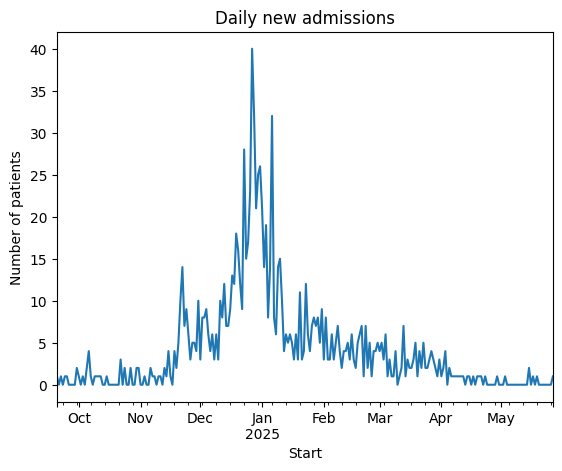

In [34]:
# Daily new admissions for the 2024-2025 season (starting from September 1, 2024)
stays_df = stays_df.loc[stays_df.Start >= pd.to_datetime('2024-09-01')]
dailies = stays_df.set_index('Start').resample('D').size()
dailies.plot(
    title='Daily new admissions',
    ylabel='Number of patients',
)

In [35]:
dailies

Start
2024-09-20    1
2024-09-21    0
2024-09-22    1
2024-09-23    0
2024-09-24    1
             ..
2025-05-23    0
2025-05-24    0
2025-05-25    0
2025-05-26    0
2025-05-27    1
Freq: D, Length: 250, dtype: int64

<Axes: title={'center': 'Admissions by hour of day'}, xlabel='Hour of day', ylabel='Probability'>

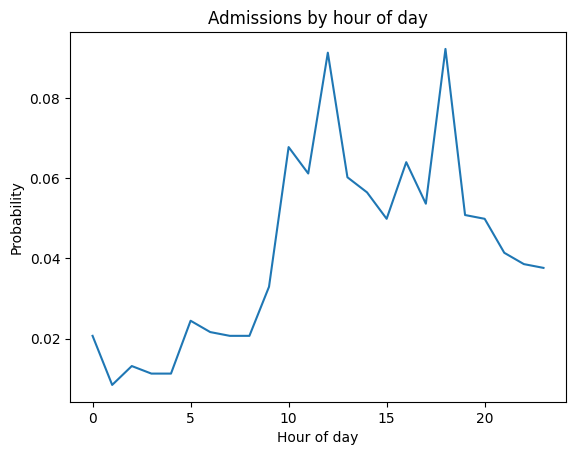

In [36]:
# Admission by hour of day
stays_df['Hour'] = stays_df.Start.dt.hour
hourlies = stays_df['Hour'].value_counts().sort_index()
hourlies /= hourlies.sum()  # convert to probabilities
hourlies.plot(
    title='Admissions by hour of day',
    xlabel='Hour of day',
    ylabel='Probability',
)

In [37]:
hourlies

Hour
0    0.0206961
1    0.0084666
2    0.0131703
3    0.0112888
4    0.0112888
5    0.0244591
6    0.0216369
7    0.0206961
8    0.0206961
9    0.0329257
10   0.0677328
11   0.0611477
12   0.0912512
13    0.060207
14    0.056444
15   0.0498589
16   0.0639699
17   0.0536218
18   0.0921919
19   0.0507996
20   0.0498589
21   0.0413923
22   0.0385701
23   0.0376294
Name: count, dtype: float64

In [38]:
hourlies.sum()

np.float64(1.0)

In [39]:
import salabim as s

@dataclass
class Scenario:
    """Defines a scenario for simulating patient arrivals."""

    dailies: pd.Series
    """Daily arrivals as a time series indexed by date."""

    hourlies: pd.Series
    """Hourly distribution of arrivals as a series indexed by hour of day (0-23).
    
    The probabilities should sum to 1.
    """

    def rand_hour(self):
        """Randomly sample an hour of day for a patient arrival based on the hourly distribution."""
        return int(random.choices(
            population=self.hourlies.index,
            weights=self.hourlies.values,
            k=1
        )[0])
    
    def rand_arr_time(self, env: s.Environment):
        """Randomly sample a patient arrival's time-of-day.
        
        Our patient generation process will first determine the number of arrivals for a day;
        then for each arrival, it will generate the arrival time-of-day using
        this method.  The patient generation process generates a batch of patients at
        the start of each day (i.e. at 00:00), and then delays each patient's arrival by the
        time-of-day generated here.

        The env parameter must support the hours() method, i.e. its time_unit cannot be None.
        """
        return env.hours(self.rand_hour() + random.uniform(0, 1))

In [40]:
scenario = Scenario(
    dailies=dailies,
    hourlies=hourlies,
)
env=s.Environment(datetime0=dailies.index.min(), random_seed='*')
scenario.rand_arr_time(env) / env.hours(1)

11.153475284468499

## Class definitions for salabim simulation

In [41]:
class Environment(s.Environment):
    """Custom environment class for our simulation."""
    def __init__(
        self,
        *args,
        scenario: Scenario,
        random_patient_generator: RandomPatientGenerator,
        jitter: float = 0,
        **kwargs
    ):
        """Set up the environment."""

        assert "datetime0" not in kwargs.keys(), (
            "`datetime0` should not be passed as an argument to Environment() as it is "
            "computed automatically from the `scenario` argument."
        )

        super().__init__(
            *args,
            datetime0=scenario.dailies.index.min(),
            **kwargs,
        )

        self.scenario = scenario
        """The scenario defining the arrival process for patients."""
        
        self.random_patient_generator = random_patient_generator
        """Generates random patient attributes according to the distributions in the data."""

        self.gim_beds = s.Resource('GIM Beds', capacity=s.inf)
        """Resource representing GIM beds.
        
        Capacity is infinite since we are not modeling bed constraints in this model,
        but we use the resource's built-in functionality to track bed occupancy."""

        self.gim_beds_by_age_group = dict[str, s.Resource]()
        """Mapping of age groups to their corresponding GIM bed resources.
        
        As with self.gim_beds, capacities are infinite and we are not modeling bed constraints.
        It is assumed each patient belongs to exactly one age group, and the groups do not
        overlap, e.g. 0-15, 16-64, 65+.

        We will initialize this as empty and populate it with a salabim.Resource for each new
        age group encountered as patients are generated.
        """

        self.icu_beds = s.Resource('ICU Beds', capacity=s.inf)
        """Resource representing ICU beds.
        
        Capacity is infinite since we are not modeling bed constraints in this model,
        but we use the resource's built-in functionality to track bed occupancy."""

        self.icu_beds_by_age_group = dict[str, s.Resource]()
        """Mapping of age groups to their corresponding ICU bed resources.
        
        As with self.icu_beds, capacities are infinite and we are not modeling bed constraints.
        It is assumed each patient belongs to exactly one age group, and the groups do not
        overlap, e.g. 0-15, 16-64, 65+.

        We will initialize this as empty and populate it with a salabim.Resource for each new
        age group encountered as patients are generated.
        """


        # Start the patient generator process by creatin an instance of RandomPatientsGenerator
        RandomPatientsGenerator(
            env=self,
            scenario=self.scenario,
            random_patient_generator=self.random_patient_generator,
            jitter=jitter
        )

class Patient(s.Component):
    """Represents a patient in the simulation."""

    def __init__(
        self,
        *args,
        env: Environment,
        delay: float = 0,
        profile: dict,
        **kwargs
    ):
        """Set up the patient.
        
        According to salabim rules, any parameters passed to Patient() not consumed by __init__,
        i.e. `profile`, will be passed to setup().

        Patients are generated by the RandomPatientsGenerator process daily at midnight,
        then delayed by `delay` before entering the system and invoking their process() method.
        Note `delay` is a float; use env.hours() to convert from hours to the environment's time
        unit.
        """
        super().__init__(*args, env=env, delay=delay, **kwargs)

        self.profile = profile
        """Patient attributes such as pathway, outcome, age group, length of stay, etc."""
    
    def process(self):
        """The main process for the patient.
        
        This will handle the patient's bed occupancy logic and eventual departure from the hospital.
        """
        self.env: Environment  # type hint for better autocompletion

        # Ensure the age group has corresponding GIM and ICU bed resources in the environment
        age_group = self.profile['age_group']
        if age_group not in self.env.gim_beds_by_age_group:
                self.env.gim_beds_by_age_group[age_group] = s.Resource(
                    f'GIM Beds Age {age_group}', capacity=s.inf
                )
        if age_group not in self.env.icu_beds_by_age_group:
            self.env.icu_beds_by_age_group[age_group] = s.Resource(
                f'ICU Beds Age {age_group}', capacity=s.inf
            )

        # Patient flow logic based on pathway
        if self.profile['pathway'] == 'gim':
            # GIM pathway
            self.request(
                self.env.gim_beds,
                self.env.gim_beds_by_age_group[age_group]
            )
            self.hold(self.env.days(self.profile['length_of_stay']))
            self.release()  # No arguments = release all resources held by this component
        
        else:  # ICU pathway
            if self.profile['pre_icu_los'] is not None:
                # Pre-ICU GIM stay
                self.request(
                    self.env.gim_beds,
                    self.env.gim_beds_by_age_group[age_group]
                )
                self.hold(self.env.days(self.profile['pre_icu_los']))
                self.release()
            
            # ICU stay
            self.request(
                self.env.icu_beds,
                self.env.icu_beds_by_age_group[age_group]
            )
            self.hold(self.env.days(self.profile['icu_los']))
            self.release()

            if self.profile['post_icu_los'] is not None:
                # Post-ICU GIM stay
                self.request(
                    self.env.gim_beds,
                    self.env.gim_beds_by_age_group[age_group]
                )
                self.hold(self.env.days(self.profile['post_icu_los']))
                self.release()

class RandomPatientsGenerator(s.Component):
    """Generates patients according to a Scenario and RandomPatientGenerator.
    
    The Scenario defines the arrival process for patients, while the RandomPatientGenerator defines
    how to generate patient attributes for each individual patient.
    """

    def __init__(
        self,
        *args,
        env: Environment,
        scenario: Scenario,
        random_patient_generator: RandomPatientGenerator,
        jitter: float = 0,
        **kwargs
    ):
        assert env.datetime0() == scenario.dailies.index.min(), (
            "Environment start time must match the start of the scenario dailies index."
        )

        assert 0 <= jitter <= 1, "Jitter must be between 0 and 1."

        super().__init__(*args, env=env, **kwargs)

        self.scenario = scenario
        """The scenario defining the arrival process for patients."""

        self.random_patient_generator = random_patient_generator
        """Generates random patient attributes according to the distributions in the data."""

        self.jitter = jitter
        """Randomness value for the number of arrivals each day.  For exactly the arrival
        numbers as specified in the scenario, set this to 0 (the default)."""
    
    def process(self):
        """The main process for generating patients."""
        self.env: Environment  # type hint for better autocompletion

        for _date, daily_count in self.scenario.dailies.items():
            # Add jitter to the daily count if specified
            if self.jitter > 0:
                daily_count = int(
                    daily_count * random.uniform(1 - self.jitter, 1 + self.jitter)
                )
                daily_count = max(daily_count, 0)  # ensure non-negative count

            for _ in range(daily_count):
                # Generate a random patient profile
                patient_profile = self.random_patient_generator.rand_patient_profile()

                # Create a new patient with the generated profile and a random arrival time
                # based on the scenario.  The delay will cause the patient to arrive at the
                # correct time of day according to the scenario's hourly distribution.
                #
                # The patient will invoke its own process() method upon creation,
                # which will handle its bed occupancy logic and eventual departure.
                Patient(
                    env=self.env,
                    delay=self.scenario.rand_arr_time(self.env),
                    profile=patient_profile,
                )

            # Advance time to the next day after generating patients for the current day
            self.hold(self.env.days(1))    

In [54]:
for _ in range(30):
    env = Environment(
        scenario=scenario,
        random_patient_generator=random_patient_generator
    )
    env.run()

## Simulation traces

In [44]:
def plot_occupancy(resource: s.Resource, title: str):
    """Plot the occupancy of a resource over time."""
    env = resource.env
    df = resource.claimed_quantity.as_dataframe()
    df.columns = ['t', 'occupancy']
    df.t = df.t.map(env.t_to_datetime)
    df.plot(x='t', y='occupancy', title=title, ylabel='Number of beds occupied')

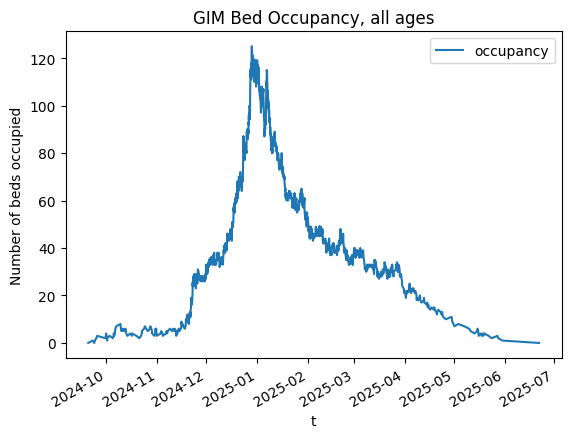

In [45]:
plot_occupancy(env.gim_beds, 'GIM Bed Occupancy, all ages')

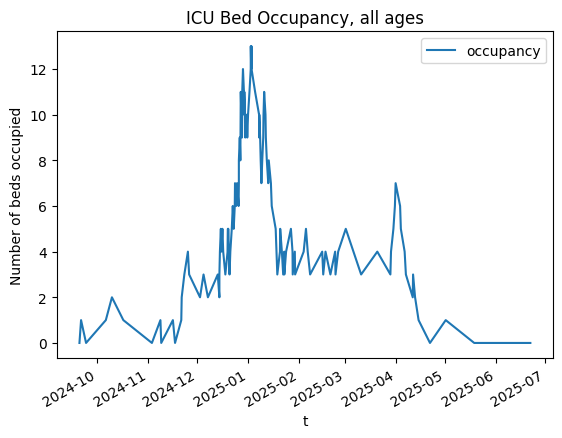

In [46]:
plot_occupancy(env.icu_beds, 'ICU Bed Occupancy, all ages')

In [47]:
env.gim_beds_by_age_group

{'16-64': Resource (GIM Beds Age 16-64),
 '0-15': Resource (GIM Beds Age 0-15),
 '65+': Resource (GIM Beds Age 65+)}

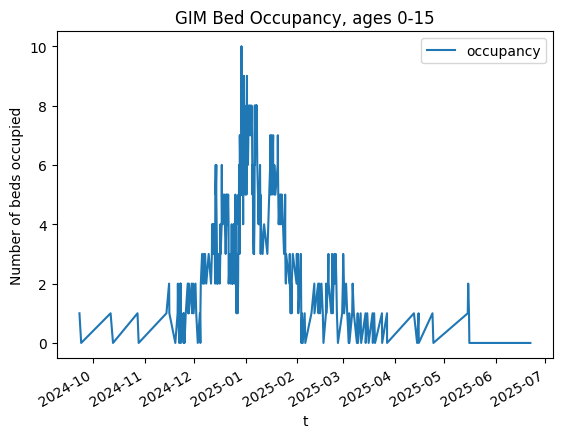

In [48]:
plot_occupancy(env.gim_beds_by_age_group['0-15'], 'GIM Bed Occupancy, ages 0-15')

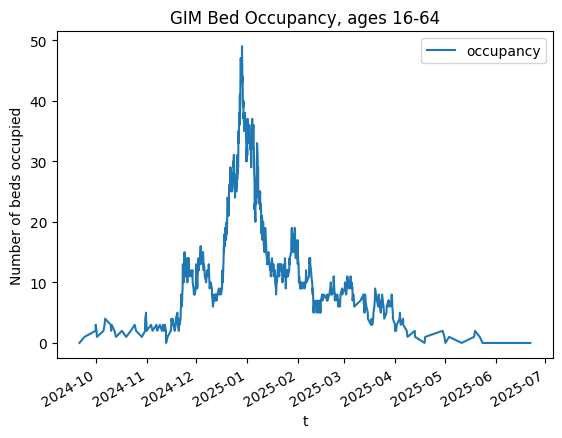

In [49]:
plot_occupancy(env.gim_beds_by_age_group['16-64'], 'GIM Bed Occupancy, ages 16-64')

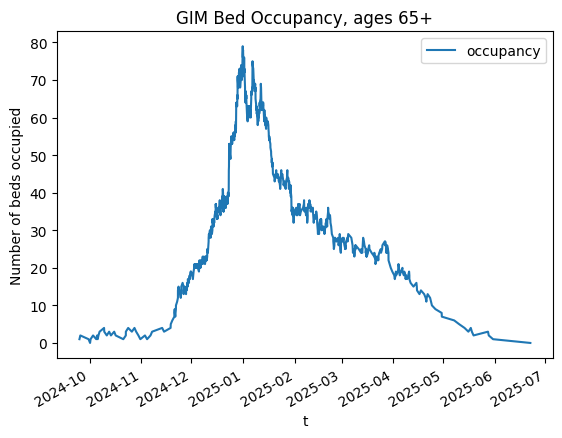

In [50]:
plot_occupancy(env.gim_beds_by_age_group['65+'], 'GIM Bed Occupancy, ages 65+')

# Excel config

In [51]:
dailies.name = 'count'
dailies.index.name = 'date'
dailies

date
2024-09-20    1
2024-09-21    0
2024-09-22    1
2024-09-23    0
2024-09-24    1
             ..
2025-05-23    0
2025-05-24    0
2025-05-25    0
2025-05-26    0
2025-05-27    1
Freq: D, Name: count, Length: 250, dtype: int64

In [52]:
hourlies.name = 'probability'
hourlies.index.name = 'hour'
hourlies

hour
0    0.0206961
1    0.0084666
2    0.0131703
3    0.0112888
4    0.0112888
5    0.0244591
6    0.0216369
7    0.0206961
8    0.0206961
9    0.0329257
10   0.0677328
11   0.0611477
12   0.0912512
13    0.060207
14    0.056444
15   0.0498589
16   0.0639699
17   0.0536218
18   0.0921919
19   0.0507996
20   0.0498589
21   0.0413923
22   0.0385701
23   0.0376294
Name: probability, dtype: float64

In [53]:
with pd.ExcelWriter('scenario.xlsx') as writer:
    dailies.to_excel(writer, sheet_name='Daily Arrivals')
    hourlies.to_excel(writer, sheet_name='Hourly Distribution')

import openpyxl

wb = openpyxl.load_workbook('scenario.xlsx')

ws = wb['Daily Arrivals']
#  Auto-adjust column widths
for column_cells in ws.iter_cols(min_col=1, max_col=ws.max_column):
    ws.column_dimensions[column_cells[0].column_letter].auto_size = True

ws = wb['Hourly Distribution']
#  Auto-adjust column widths
for column_cells in ws.iter_cols(min_col=1, max_col=ws.max_column):
    ws.column_dimensions[column_cells[0].column_letter].auto_size = True
# Turn column B into percentage format, skipping B1
for cell in ws['B'][1:]:
    cell.number_format = '0.000%'

wb.save('scenario.xlsx')